In [18]:
import cv2
from matplotlib import pyplot as plt
from skimage.io import imread, imshow, imsave
import numpy as np
import pydicom as dcm
from skimage import morphology

def curve(fileName,fileNamSave):
    try:
        #img=imread('rice.png')
        img=cv2.imread(fileName)
        # ds=dcm.dcmread('/kaggle/input/mias-mammography/all-mias/mdb001.pgm')
        # img=ds.pixel_array
        image_bw = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
 
        # The declaration of CLAHE
        # clipLimit -> Threshold for contrast limiting
        clahe = cv2.createCLAHE(clipLimit = 5)
        final_img = clahe.apply(image_bw)
        hist,bins=np.histogram(img,bins=256)
        X=bins[0:-1]

        p=np.polyfit(X,hist,6)

        Y=np.polyval(p,X)

        dY=np.diff(Y)
        d2Y=np.diff(dY)

        dY_abs=np.sort(np.abs(dY))
        ind=np.argsort(np.abs(dY))

        d2Y_abs=np.diff(dY_abs)
        voluem=np.min(d2Y_abs)
        i=np.argmin(d2Y_abs)

        thresh=ind[i]

        thresh_img=cv2.threshold(final_img,thresh,255,cv2.THRESH_BINARY)[1]
        thresh_img = thresh_img.astype(np.uint8)
        (cnts, _) = cv2.findContours(thresh_img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        segmented = max(cnts, key=cv2.contourArea)

        (x,y,w,h) = cv2.boundingRect(segmented)
        crop_img=final_img[y:y+h,x:x+w]

        #cv2.rectangle(thresh_img,(x,y),(x+w, y+h), (255,255,255), 2)
        #plt.plot(X,hist,'r-',X,Y,'b-')
        #plt.imshow(crop_img)
        plt.imsave(fileNamSave,crop_img)
    
        return 'Y'
    except:
        plt.imsave(fileNamSave,img)
        
        return 'N'

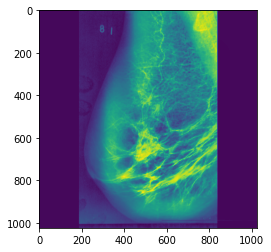

In [19]:
img=cv2.imread('D:\\Bigdata\\ha\\curve\\all-mias\\mdb027.pgm',1)
# ds=dcm.dcmread('/kaggle/input/mias-mammography/all-mias/mdb001.pgm')
# img=ds.pixel_array
image_bw = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# The declaration of CLAHE
# clipLimit -> Threshold for contrast limiting
clahe = cv2.createCLAHE(clipLimit = 5)
final_img = clahe.apply(image_bw) 
plt.imshow(final_img)
plt.show()

In [20]:
curve('D:\\Bigdata\\ha\\curve\\all-mias\\mdb135.pgm','D:\\Bigdata\\ha\\curve\\dataset\\mdb135.png')

'N'

In [ ]:
no_angles = 360
url ='D:/Bigdata/ha/curve/all-mias/'
saveUrl='D:/Bigdata/ha/curve/dataset/'

Đọc các bức ảnh trong bộ dữ liệu ALL-mias

In [ ]:
def read_image():
    print("Reading images")
    import cv2
    info = {}
    for i in range(322):
        if i<9:
            image_name='mdb00'+str(i+1)
        elif i<99:
            image_name='mdb0'+str(i+1)
        else:
            image_name = 'mdb' + str(i+1)
        # print(image_name)
        image_address= url+image_name+'.pgm'
        save_address=saveUrl+image_name+'.png'
        # print(image_address)
        
        result= curve(image_address,save_address) 
        # print(i)
        # img = cv2.resize(img, (227,227))   #resize image
        
        img = cv2.imread(save_address,1)
        rows, cols,color = img.shape
        info[image_name]={}
        for angle in range(0,no_angles,8):
            M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)    #Rotate 0 degree
            img_rotated = cv2.warpAffine(img, M, (cols, rows))
            info[image_name][angle]=img_rotated
    return (info)

In [ ]:
def read_lable():
    print("Reading labels")
    filename = url+'Info.txt'
    text_all = open(filename).read()
    #print(text_all)
    lines=text_all.split('\n')
    info={}
    for line in lines:
        words=line.split(' ')
        if len(words)>3:
            if (words[3] == 'B'):
                info[words[0]] = {}
                for angle in range(0,no_angles,2):
                    info[words[0]][angle] = 0
            if (words[3] == 'M'):
                info[words[0]] = {}
                for  angle in range(0,no_angles,2):
                    info[words[0]][angle] = 1
    return (info)

In [ ]:
lable_info=read_lable()
image_info=read_image()

Reading labels
Reading images


In [23]:
def read_image1():
    print("Reading images")
    import cv2
    info = {}
    for i in range(322):
        if i<9:
            image_name='mdb00'+str(i+1)
        elif i<99:
            image_name='mdb0'+str(i+1)
        else:
            image_name = 'mdb' + str(i+1)
        # print(image_name)
        image_address= url+image_name+'.pgm'
        #print(image_address)
        #print(image_address)
        img = cv2.imread(image_address, 0)
        # print(i)
        try:
            img = cv2.resize(img,dsize= (227,227))   #resize image
            rows, cols = img.shape
            info[image_name]={}
            for angle in range(0,no_angles,2):
                M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)    #Rotate 0 degree
                img_rotated = cv2.warpAffine(img, M, (cols, rows))
                info[image_name][angle]=img_rotated
        except:
                print(image_address)
    return (info)

In [24]:
from sklearn.model_selection import train_test_split
import numpy as np
lable_info=read_lable()
image_info=read_image1()
ids=lable_info.keys()   #ids = acceptable labeled ids
#print(type(ids))
del lable_info['Truth-Data:']
#print(lable_info)
#print(ids)
X=[]
Y=[]
for id in ids:
    for angle in range(0,no_angles,2):
        X.append(image_info[id][angle])
        Y.append(lable_info[id][angle])
X=np.array(X)
Y=np.array(Y)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.15,shuffle=True, random_state=2021)
(a,b,c)=x_train.shape  # (60000, 28, 28)
x_train = np.reshape(x_train, (a, b, c, 1))  #1 for gray scale
(a, b, c)=x_test.shape
x_test = np.reshape(x_test, (a, b, c, 1))   #1 for gray scale
# cancer_prediction_cnn(x_train, y_train, x_test, y_test)

Reading labels
Reading images


In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPool2D, Flatten
from keras import optimizers
from keras import losses
from sklearn import metrics

rows, cols,color = x_train[0].shape
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='valid', strides=(1, 1),input_shape=(227,227,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', strides=(1, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2),strides=2))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same', strides=(1, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2),strides=2))

model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2),strides=2))

model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 225, 225, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 225, 225, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 225, 225, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 64)    

In [25]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', patience=8,restore_best_weights=True, verbose=1)

In [26]:
model.compile(optimizer='RMSprop',loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train,validation_split=0.2, epochs=100,shuffle=True, batch_size=128,callbacks=[es])
loss_value , accuracy = model.evaluate(x_test, y_test)

print('Test_loss_value = ' +str(loss_value))
print('test_accuracy = ' + str(accuracy))

#print(model.predict(x_test))
#model.save('breast_cance_model.h5')

save_dictionary('history1.dat', history.history)

Epoch 1/100
110/110 [==============================] - 1015s 9s/step - loss: 6.9936 - accuracy: 0.5466 - val_loss: 6.9783 - val_accuracy: 0.5476
Epoch 2/100
 11/110 [==>...........................] - ETA: 13:01 - loss: 7.2304 - accuracy: 0.5312

KeyboardInterrupt: 